# Field Validation

In [3]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [4]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_updated.csv')

In [5]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape
#Reshape data for LSTM (add time step dimension)
test_data_scaled_normal = test_data_scaled_normal.values.reshape(test_data_scaled_normal.shape[0], 1, test_data_scaled_normal.shape[1])
test_data_scaled_abnormal = test_data_scaled_abnormal.values.reshape(test_data_scaled_abnormal.shape[0], 1, test_data_scaled_abnormal.shape[1])
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape


((2502, 1, 100), (184, 1, 100))

In [11]:
# Make predictions using autoencoder
lstm = tf.keras.models.load_model('../../models/lstm_autoencoder_best.keras')
with open('../../models/lstm_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


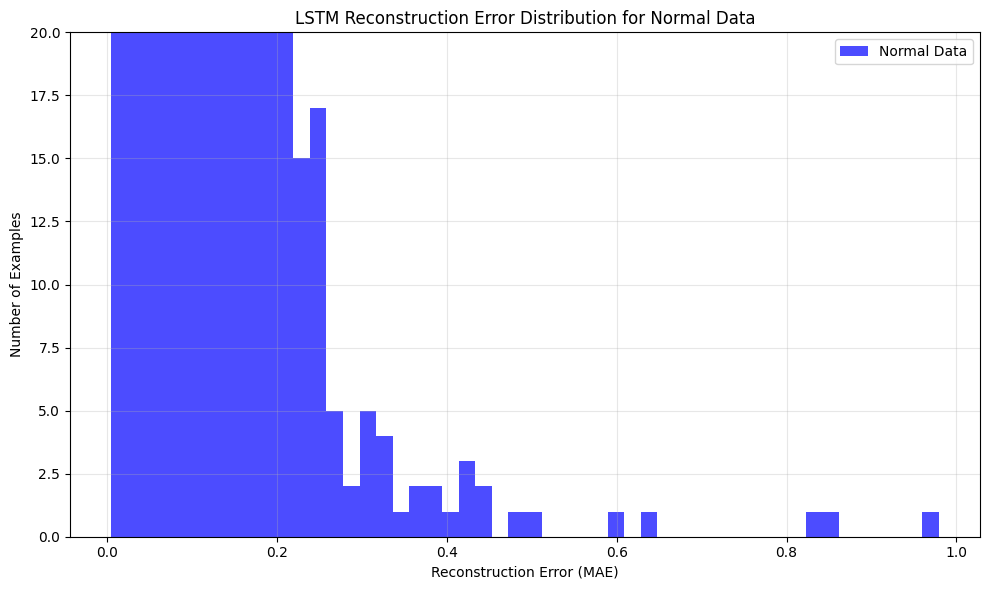

In [22]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = lstm.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Normal Data')

plt.title('LSTM Reconstruction Error Distribution for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0,20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


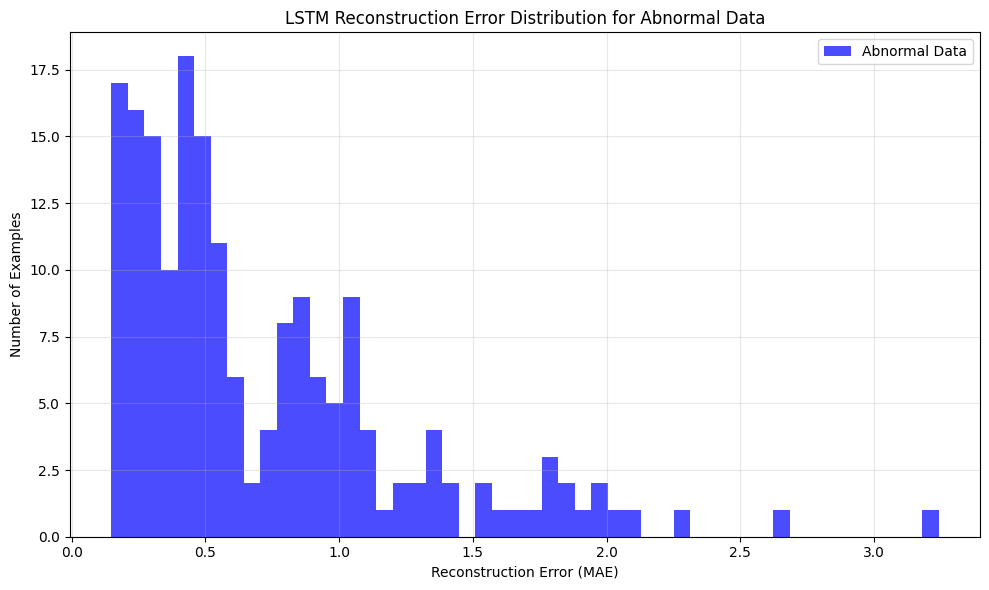

Mean reconstruction error: 0.1489
Median reconstruction error: 0.5323
Standard deviation: 0.5335


In [21]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = lstm.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_abnormal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Abnormal Data')

plt.title('LSTM Reconstruction Error Distribution for Abnormal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean reconstruction error: {np.min(train_loss_abnormal):.4f}")
print(f"Median reconstruction error: {np.median(train_loss_abnormal):.4f}")
print(f"Standard deviation: {np.std(train_loss_abnormal):.4f}")

In [111]:
# Find indices where reconstruction error is between 0.45 and 0.5
train_loss_abnormal_np = train_loss_abnormal.numpy()  # Convert to numpy array
abnormal_high_error_idx = np.where((train_loss_abnormal_np > 0.49) & (train_loss_abnormal_np <0.5))[0]

In [112]:
# Get original DataFrame rows for high error indices with additional information
abnormal_high_error_info = df[df['curb_scene'] == 1].iloc[abnormal_high_error_idx][['start_time', 'end_time', 'curb_scene']]

# for idx, row in abnormal_high_error_info.iterrows():
#     error_value = train_loss_abnormal_np[abnormal_high_error_idx][abnormal_high_error_info.index.get_loc(idx)]
#     pd.set_option('display.max_rows', None)
#     print(f"{idx}:{row['start_time']} to {row['end_time']} {error_value:.3f}")

# # Summary statistics
# print("\nSummary:")
# print(f"Number of high-error abnormal segments: {len(abnormal_high_error_info)}")


In [113]:
print(abnormal_high_error_info.index.tolist())

[1638, 2490, 2646, 2672]


In [114]:
len(abnormal_high_error_info.index.tolist())

4

In [90]:
df.iloc[2672].curb_scene

np.int64(1)